In [3]:
import bs4
import requests
import pandas as pd

BASE_URL = "https://www.otodom.pl/pl/oferty/wynajem/mieszkanie/wiele-lokalizacji?distanceRadius=0&page={}&limit=72&market=ALL&media=%5B%5D&extras=%5B%5D&locations=%5Bdistricts_6-2%2Cdistricts_6-1%5D&viewType=listing"
NUMBER_OF_PAGES = 4

all_rows = []

# visit all pages with offers
for i in range(NUMBER_OF_PAGES):
    # make a http request
    response = requests.get(BASE_URL.format(i))

    soup = bs4.BeautifulSoup(response.content, "html.parser")

    # the offers are separated in 'article' tags, find them
    offers = soup.find_all("article", class_="css-qqu0du es62z2j16")

    for offer in offers:
        # different values that we need are organized in 'span' tags
        offer_values = offer.find_all("span", class_="css-rmqm02 eclomwz0")

        # we need to replace unnecessary characters
        price = offer_values[0].text.replace("zł/mc", "").replace(" ", "")
        rooms = offer_values[1].text.split()[0]
        area = offer_values[2].text.split()[0]

        new_row = [int(price), int(rooms), float(area)]
        all_rows.append(new_row)

# create a dataframe with all the data
df = pd.DataFrame(all_rows, columns=["price", "rooms", "area"])

# save all data to csv file in case website down or other problems
df.to_csv("otodom_data.csv")


In [14]:
# make sure the datatypes are correct
df.dtypes
dr = pd.read_csv("otodom_data.csv")


In [15]:
# cleaning data
# remove offers with 1 room in a big apartment, which only rent 1 room but the number of rooms
# is for the whole apartment
df = df.loc[~((df["rooms"] > 4) & (df["area"] < 15))]

# we don't remove duplicates, there could be 2 unique apartments with the same price, area,
# and number of rooms


/home/szymon/dev/regression_testing/venv/lib64/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/home/szymon/dev/regression_testing/venv/lib64/python3.10/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


""


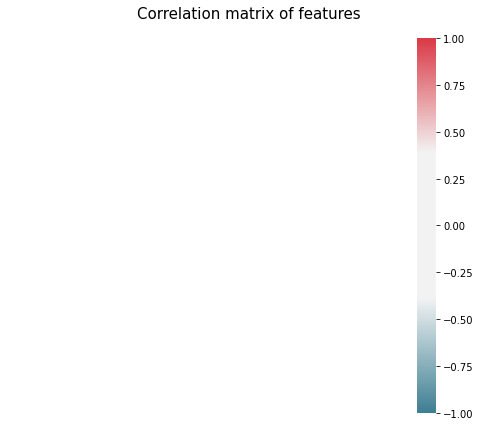

In [16]:
# visualize the correlation between our data

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr()

# generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
fig, ax = plt.subplots(figsize=(7, 6))

# generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=0.5)

# add title
fig.suptitle("Correlation matrix of features", fontsize=15)


fig.tight_layout()
corr


In [17]:
from sklearn.model_selection import train_test_split

# features that we supply
features = ["rooms", "area"]
# our target variable that we want to predict
target = "price"

x = df[features].values.reshape(-1, len(features))
y = df[target].values

# splitting data into training and testing set
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)


ValueError: With n_samples=0, test_size=0.1 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from sklearn import linear_model

# creating the linear regression
lr = linear_model.LinearRegression()
model = lr.fit(x_train, y_train)


In [ ]:
# checking the coefficients of our model
model.coef_


array([-175.38644658,   89.95388086])

In [ ]:
# checking the intercept of our model
model.intercept_


-535.4435848123817

In [ ]:
# checking the score of our model
model.score(x, y)


0.5017648090825297

Underneath, we visualize the predictions of our model on a few different graphs

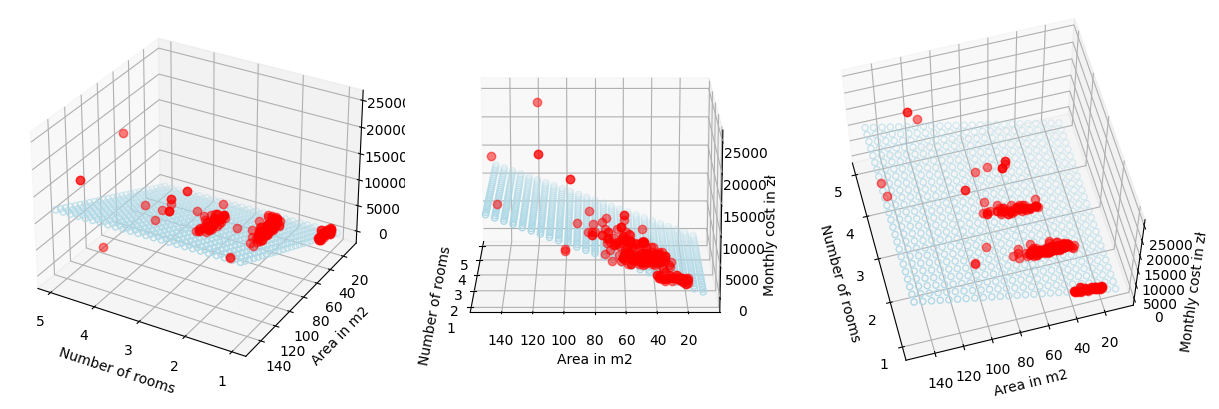

In [ ]:
# visualizing with training datapoints

x_vis = x_train[:, 0]
y_vis = x_train[:, 1]
z_vis = y_train

x_space = np.linspace(1, 5, 25)  # range of rooms values
y_space = np.linspace(10, 150, 25)  # range of area values
xx_pred, yy_pred = np.meshgrid(x_space, y_space)
model_vis = np.array([xx_pred.flatten(), yy_pred.flatten()]).T


predicted = model.predict(model_vis)


plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

# we will add 3 different angles
ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(
        x_vis,
        y_vis,
        z_vis,
        color="red",
        zorder=15,
        linestyle="none",
        marker="o",
        alpha=0.5,
    )
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="lightblue",
    )
    ax.set_xlabel("Number of rooms", fontsize=10)
    ax.set_ylabel("Area in m2", fontsize=10)
    ax.set_zlabel("Monthly cost in zł", fontsize=10)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")

ax1.view_init(elev=30, azim=120)
ax2.view_init(elev=15, azim=180)
ax3.view_init(elev=60, azim=165)

fig.tight_layout()


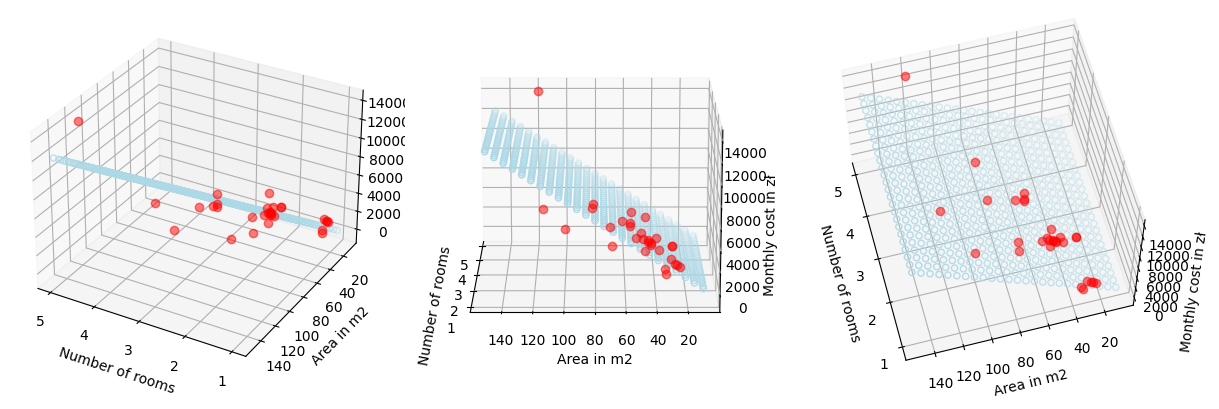

In [ ]:
# visualizing with testing datapoints

x_vis = x_test[:, 0]
y_vis = x_test[:, 1]
z_vis = y_test

x_space = np.linspace(1, 5, 25)  # range of rooms values
y_space = np.linspace(10, 150, 25)  # range of area values
xx_pred, yy_pred = np.meshgrid(x_space, y_space)
model_vis = np.array([xx_pred.flatten(), yy_pred.flatten()]).T


predicted = model.predict(model_vis)


plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

# we will add 3 different angles
ax1 = fig.add_subplot(131, projection="3d")
ax2 = fig.add_subplot(132, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax2, ax3]

for ax in axes:
    ax.plot(
        x_vis,
        y_vis,
        z_vis,
        color="red",
        zorder=15,
        linestyle="none",
        marker="o",
        alpha=0.5,
    )
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="lightblue",
    )
    ax.set_xlabel("Number of rooms", fontsize=10)
    ax.set_ylabel("Area in m2", fontsize=10)
    ax.set_zlabel("Monthly cost in zł", fontsize=10)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")

ax1.view_init(elev=30, azim=120)
ax2.view_init(elev=15, azim=180)
ax3.view_init(elev=60, azim=165)

fig.tight_layout()


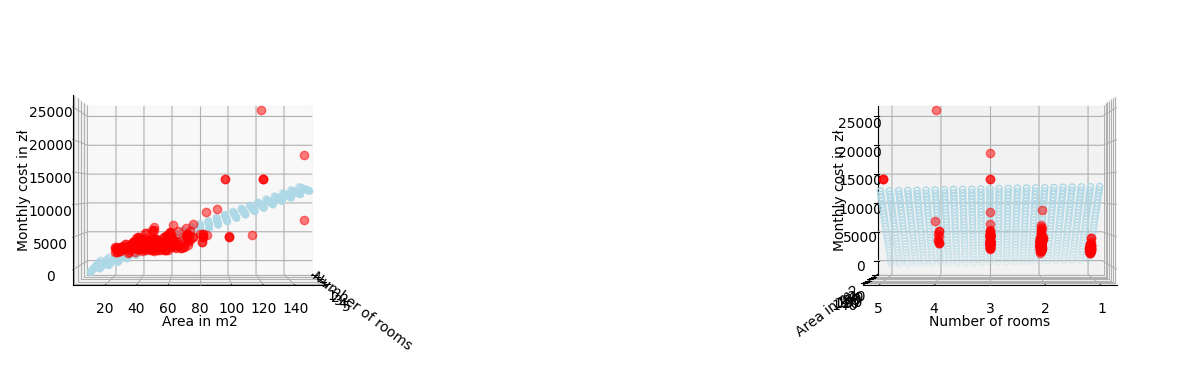

In [ ]:
# side view visualization with all the data

x_vis = x[:, 0]
y_vis = x[:, 1]
z_vis = y


plt.style.use("default")

fig = plt.figure(figsize=(12, 4))

# we will add 2 different angles
ax1 = fig.add_subplot(131, projection="3d")
ax3 = fig.add_subplot(133, projection="3d")

axes = [ax1, ax3]


for ax in axes:
    ax.plot(
        x_vis,
        y_vis,
        z_vis,
        color="r",
        zorder=15,
        linestyle="none",
        marker="o",
        alpha=0.5,
    )
    ax.scatter(
        xx_pred.flatten(),
        yy_pred.flatten(),
        predicted,
        facecolor=(0, 0, 0, 0),
        s=20,
        edgecolor="lightblue",
    )
    ax.set_xlabel("Number of rooms", fontsize=10)
    ax.set_ylabel("Area in m2", fontsize=10)
    ax.set_zlabel("Monthly cost in zł", fontsize=10)
    ax.locator_params(nbins=4, axis="x")
    ax.locator_params(nbins=5, axis="x")

ax1.view_init(elev=0, azim=0)
ax3.view_init(elev=0, azim=90)

fig.tight_layout()


In [ ]:
# example prediction
example_apartment_data = np.array([[3, 60], [2, 40], [1, 25]])
example_apartment_data = example_apartment_data.reshape(-1, len(features))
model.predict(example_apartment_data)


array([4335.6299273 , 2711.9387566 , 1538.01699021])

In [ ]:
# comparison with the same area but different number of rooms
example_apartment_data = np.array([[1, 50], [2, 50], [3, 50]])
example_apartment_data = example_apartment_data.reshape(-1, len(features))
model.predict(example_apartment_data)


NameError: name 'np' is not defined